# Prequisites

In [14]:
import os
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use("ggplot")

from torch.utils.data import Dataset
import torchvision
from torchvision.io import read_image, ImageReadMode
from torch.utils.data import DataLoader
import torch
import time
from tqdm.notebook import tqdm
from tempfile import TemporaryDirectory
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter # For tensorboard support

ModuleNotFoundError: No module named 'tensorboard'

In [2]:
main_dir = "raw-img"
dic = {}

for i in os.listdir(main_dir):
    img_folder = os.path.join(main_dir, i)
    count = len(os.listdir(img_folder))
    dic[i] = count

<BarContainer object of 10 artists>

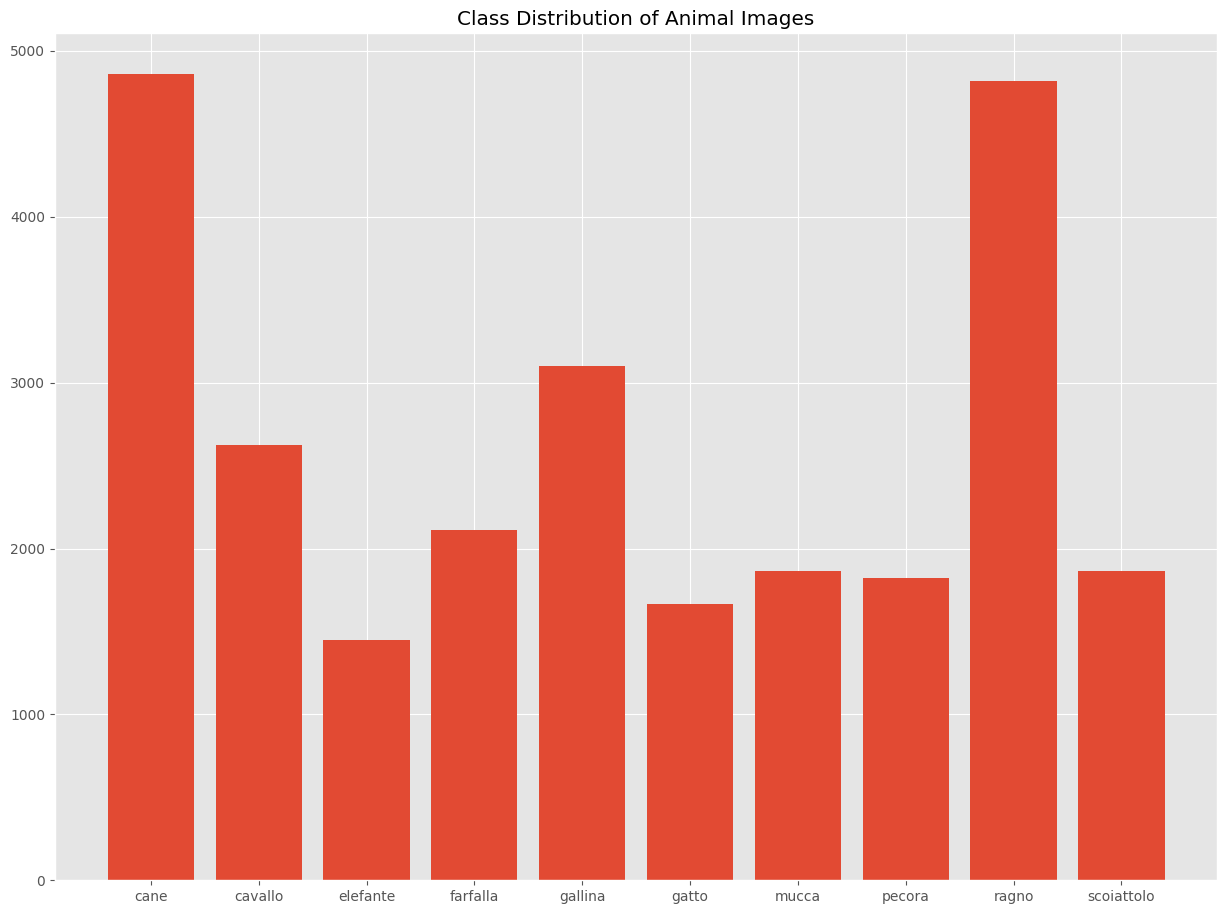

In [3]:
x = list(dic.keys())
y = list(dic.values())
plt.figure(figsize=(15, 11)) #Width , height
plt.title("Class Distribution of Animal Images")
plt.bar(x, y)

In [4]:
#Creating encoded labels for the animals 

animal_key = {}
count = 0 
main_dir = "raw-img"

for i in os.listdir(main_dir):
    animal_key[i] = count
    count += 1 
animal_key

{'cane': 0,
 'cavallo': 1,
 'elefante': 2,
 'farfalla': 3,
 'gallina': 4,
 'gatto': 5,
 'mucca': 6,
 'pecora': 7,
 'ragno': 8,
 'scoiattolo': 9}

In [5]:
#Creating a csv with image paths before using our custom data loader

main_dir = "raw-img" 
img_paths = []
labels = []

for i in os.listdir(main_dir):
    img_folder = os.path.join(main_dir, i)
    for j in os.listdir(img_folder):
        img_path = os.path.join(img_folder, j)
        img_paths.append(img_path)
        labels.append(animal_key[i])

data = pd.DataFrame([img_paths, labels])
data = data.transpose()
data.to_csv("info.csv", index=None)

In [6]:
class CustomDatasetLoader(Dataset):
    def __init__(self, csv_path, transform=None): #Init function runs only once when instantiating the Dataset object
        self.img_info = pd.read_csv(csv_path)
        self.transform = transform

    def __len__(self): #Returns the total number of data points
        return len(self.img_info)

    def __getitem__(self, index): #Should return the image and label from the data source as per the "index" value iterated over the length
        img_path = self.img_info.iloc[index, 0]
        img = read_image(img_path, mode=ImageReadMode.RGB)
        label = self.img_info.iloc[index, 1]
        if self.transform:
            img = self.transform(img)
        return img, label 

In [28]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((128, 128)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])

#The values for normalization and standardization are given as per the recommended values from https://pytorch.org/vision/0.9/models.html

In [29]:
train_data = CustomDatasetLoader("info.csv", train_transform)
train_loader = DataLoader(train_data, shuffle=True, batch_size=64)

# Basic Transfer Learning

Fixed Feature Extractor

All the layers are frozen except for the last classification layer/s which is also modified as the number of classes prediction has to be same as our use case

In [9]:
model = torchvision.models.mobilenet_v3_small(pretrained=True)

c:\Users\prish\miniconda3\envs\temp\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\prish\miniconda3\envs\temp\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
for parameter in model.parameters():
    parameter.requires_grad = False #the .requires_grad=True by default for all layers

model.classifier[-1] = torch.nn.Linear(1024, 10) #We have 10 classes in our data

for i in model.classifier.parameters():
    i.requires_grad = True 

In [11]:
#Defining device 

if torch.cuda.is_available():
    print("GPU Available")
    device = torch.device("cuda")
else:
    print("Device is CPU")
    device = torch.device("cpu")

model = model.to(device)

GPU Available


In [12]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
#Decay LR by a factor of 0.1 every 5 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [34]:
#timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
#writer = SummaryWriter("runs/classifier_{}".format(timestamp))

epoch_number = 0
training_accuracy_list = []
training_loss_list = []

def model_training(total_epochs, optimizer, criterion, model, device):
    for epoch in range(total_epochs):
        print(f"Epoch :{epoch}")

        #Make model trainable | Gradien tracking is on 
        model.train()
        #One pass over data
        running_loss = 0.
        running_accuracy = 0.

        for inputs, targets in tqdm(train_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            optimizer.zero_grad() #Zero the gradients for every batch
            outputs = model(inputs) #Predictions for this batch
            loss = criterion(outputs, targets) #Computer loss and its gradients
            loss.backward()
            optimizer.step() #Adjust learning weights 
            running_loss += loss.item()
            training_loss_list.append(running_loss)
            outputs.round() == targets)

        training_accuracy_result = float(running_accuracy / len(targets))
        loss_result = float(running_loss / len(targets))
        print(f"For Batch size {len(i)} images\nLoss ={loss_result}") 
        print(f"Training Accuracy : {training_accuracy_result}")
    return model 


In [35]:
model = model_training(10, optimizer, criterion, model, device)

Epoch :0


  0%|          | 0/410 [00:00<?, ?it/s]

RuntimeError: a Tensor with 64 elements cannot be converted to Scalar